In [10]:
%pylab inline
import tensorflow as tf


Populating the interactive namespace from numpy and matplotlib


In [121]:
sample_size = 64*64
band_num = 3

# X is 3 band normal multivariate with slight correlation between samples
X = np.random.multivariate_normal([0,2,3],[[1,-0.9,0.1],
                                           [-0.9,1,0.3],
                                           [0.1,0.3,1]],size=sample_size)

# Now set Y setting explisitly coefficents for CCA to recover and add some multivariate noise
Y = np.concatenate( 
    (
    ( X[:,0]*0.3+X[:,1]*-0.2+X[:,2]*0.4 )[:,np.newaxis],
    ( X[:,0]*-0.02+X[:,1]*1.2+X[:,2]*2.4 )[:,np.newaxis],
    ( X[:,0]*0.2+X[:,1]*-0.1+X[:,2]*0.03 )[:,np.newaxis],
    ),
    axis=1
) + np.random.normal(0,0.3,size=(sample_size,3))+1

xx_cov = np.cov(X,X,rowvar=False)[:3,:3]
xy_cov = np.cov(X,Y,rowvar=False)[:3,3:6]
yy_cov = np.cov(Y,Y,rowvar=False)[:3,:3]

a_pivot = np.random.normal(0,1,size=(band_num,1))
b_pivot = np.random.normal(0,1,size=(band_num,1))

In [364]:
def correlation(a,b,xx_cov,xy_cov,yy_cov):
    numerator = np.matmul( np.matmul(a.T,xy_cov), b )
    denominator = np.sqrt( np.matmul(np.matmul( a.T, xx_cov ),a) )*np.sqrt( np.matmul(np.matmul( b.T, yy_cov ),b) )
    return numerator/denominator
  
def correlation_grad_a(a,b,xx_cov,xy_cov,yy_cov):
    numerator = np.matmul( np.matmul(a.T,xy_cov), b )
    numerator_derivative = np.matmul(xy_cov, b )
    denominator = np.sqrt( np.matmul(np.matmul( a.T, xx_cov ),a) )
    denominator_derivative = np.matmul(xx_cov,a)/denominator
    multiplier = 1/np.sqrt( np.matmul(np.matmul( b.T, yy_cov ),b) )
    return multiplier*(denominator*numerator_derivative - denominator_derivative*numerator)/denominator**2

def correlation_grad_b(a,b,xx_cov,xy_cov,yy_cov):
    numerator = np.matmul( np.matmul(a.T,xy_cov), b )
    numerator_derivative = np.matmul(xy_cov.T, a )
    denominator = np.sqrt( np.matmul(np.matmul( b.T, yy_cov ),b) )
    denominator_derivative = np.matmul(yy_cov,b)/denominator
    multiplier = np.sqrt( np.matmul(np.matmul( a.T, xx_cov ),a) )
    return multiplier*(denominator*numerator_derivative - denominator_derivative*numerator)/denominator**2
    
    
def correlation(ab,*args):
    n_bands = int(ab.size/2)
    a = ab[:n_bands]
    b = ab[n_bands:]
    return correlation(a,b,*args)

def correlation_grad(ab, *args):
    n_bands = int(ab.size/2)
    a = ab[:n_bands]
    b = ab[n_bands:]
    a_grad = correlation_grad_a(a,b,*args)
    b_grad = correlation_grad_b(a,b,*args)
    return np.concatenate((a_grad,b_grad))
    #return (np.matmul(xy_cov,b)/np.power(np.matmul( np.matmul(a.T,xx_cov), a),1/2)-\
    #       np.matmul(xx_cov,a)*( np.matmul( np.matmul(a.T,xy_cov), b ) )/np.power(np.matmul( np.matmul(a.T,xx_cov), a),3/2))/\
    #       np.sqrt( np.matmul(np.matmul( b.T, yy_cov ),b) )

In [365]:
ab_pivot = np.concatenate((a_pivot,b_pivot))

func(ab_pivot,xx_cov,xy_cov,yy_cov)

array([[-0.94811014]])

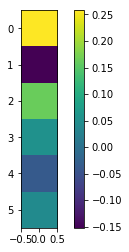

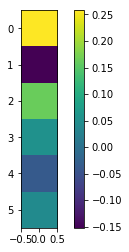

In [369]:
def calc_gradient(foo,pivot,epsilon=0.00001):
    
    grad = []
    for i in range(pivot.size):
        p1 = np.array(pivot)
        p2 = np.array(pivot)
        
        p1[i] -= epsilon
        p2[i] += epsilon
        
        grad.append( (foo(p2)-foo(p1))[0]/(epsilon*2) )
        
    return np.array(grad)

grad1 = calc_gradient(lambda x: func(x,xx_cov,xy_cov,yy_cov),ab_pivot) 
imshow( grad1 )
colorbar();
show();

grad2 = func_grad(ab_pivot,xx_cov,xy_cov,yy_cov)
imshow(grad2);
colorbar()
show();

In [367]:
print( grad1-grad2 )


[[ -5.68446956e-11]
 [  3.32618377e-11]
 [  3.75298959e-11]
 [  1.01905290e-12]
 [ -1.27394970e-11]
 [ -5.86616172e-12]]


In [368]:
print( grad1/grad2 )

[[ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]]


In [491]:
import importlib
import CCA_calc
importlib.reload(CCA_calc)

<module 'CCA_calc' from '/home/artef/IdeaProjects/prrnmosaic/python_scripts/CCA_calc.py'>

In [422]:
from scipy.optimize import minimize

In [497]:
def rosen(x):
    """The Rosenbrock function"""
    return sum(100.0*(x[1:]-x[:-1]**2.0)**2.0 + (1-x[:-1])**2.0)

def rosen_der(x):
    xm = x[1:-1]
    xm_m1 = x[:-2]
    xm_p1 = x[2:]
    der = np.zeros_like(x)
    der[1:-1] = 200*(xm-xm_m1**2) - 400*(xm_p1 - xm**2)*xm - 2*(1-xm)
    der[0] = -400*x[0]*(x[1]-x[0]**2) - 2*(1-x[0])
    der[-1] = 200*(x[-1]-x[-2]**2)
    return der

In [498]:
x0 = ab_initial
minimize(rosen, x0, method='BFGS', jac=rosen_der, options={'disp': True})

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 46
         Function evaluations: 62
         Gradient evaluations: 62


      fun: 1.0697540647456136e-14
 hess_inv: array([[ 0.00320136,  0.00384583,  0.00633666,  0.01215018,  0.02391073,
         0.04769328],
       [ 0.00384583,  0.00763998,  0.01265988,  0.0242663 ,  0.04780204,
         0.09546152],
       [ 0.00633666,  0.01265988,  0.02587752,  0.04940634,  0.09743087,
         0.19434375],
       [ 0.01215018,  0.0242663 ,  0.04940634,  0.09929687,  0.19573633,
         0.39040987],
       [ 0.02391073,  0.04780204,  0.09743087,  0.19573633,  0.39086314,
         0.77943929],
       [ 0.04769328,  0.09546152,  0.19434375,  0.39040987,  0.77943929,
         1.55942484]])
      jac: array([ -7.93365580e-07,   5.97451263e-08,  -7.15148644e-07,
         4.00937425e-06,  -5.12612252e-07,  -5.98174354e-07])
  message: 'Optimization terminated successfully.'
     nfev: 62
      nit: 46
     njev: 62
   status: 0
  success: True
        x: array([ 1.        ,  1.        ,  1.00000001,  1.00000002,  1.00000003,
        1.00000005])

In [454]:
cca = CCA_calc.CCA(3)
cca.push(X,Y)

ab_initial = cca.calc_ab()
initial_correlation = cca.calc_correlation()
print(initial_correlation)

def cor_func(ab):
    return -cca.correlation(ab)

def cor_func_grad(ab):
    return -cca.correlation_grad(ab)

0.992248869217


In [490]:
x0 = ab_initial
#minimize(cor_func, x0, method='BFGS', jac=cor_func_grad, options={'disp': True})
opt_res = minimize(cor_func, np.array([1,1,1,1,1,1]), method = 'SLSQP', jac=cor_func_grad)

opt_res

     fun: -0.9945553266498987
     jac: array([ 0.00340253, -0.00225445,  0.00124279, -0.00532665, -0.00110947,
       -0.00388519])
 message: 'Optimization terminated successfully.'
    nfev: 106
     nit: 26
    njev: 26
  status: 0
 success: True
       x: array([ 0.02214073,  1.1327496 ,  1.99465793, -0.24871667,  3.37948239,
       -0.6232777 ])

In [505]:
import importlib
import CCA_calc
importlib.reload(CCA_calc)

cca = CCA_calc.CCA(3)
cca.push(X,Y)

cca.correlation( cca.calc_ab_adv() )

0.99455532664989865